In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MABarbadillo/
%cd 'SPTProject/Rosetta'
import os

In [ ]:
##Install rosetta

!pip install rosetta-soil
from rosetta import rosetta, SoilData

In [3]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [ ]:
acme_data = loadmat('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/ACMEdeltaT.mat')
df = pd.DataFrame(acme_data['ACMEdeltaT'])
tr60_data = [float(df.iloc[i, 4]) for i in range(2, len(df))]   #Extracts the TR60 starting from row 3 in column 5 as a float (python starts counting at 0)

## Calculate the matric_potential using Illston et al. (2008) equation
c = 0.717    #kPa
a = 1.788    #1/degree Celcius
mp_60_Ill = [-c*np.exp(a*tr60_data[i]) for i in range(len(tr60_data))]   #kPa

## Calculate the matric_potential using Zhang et al. (2019) equation
mp_60_Zha = [-2083/(1+np.exp(-3.35*(tr60_data[i]-3.17))) for i in range(len(tr60_data))]    #kPa

# Read the 'MesoSoilv1_3.csv' file, skipping the first row
# Integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/MesoSoilv1_3.csv', header=0, skiprows=1)
data = df1.iloc[5: , [2, 3, 4, 5, 6, 7]].values.tolist()   #integer 5 specifies that the data reading starts at the 6th row (data at 60 cm depth is at the 6th row)
K0 = float(df1.iloc[5, 13])

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

# Extract the hydraulic parameter values from the array
# Rosetta Ver.1
theta_r1 = float(mean_1[0][0])
theta_s1 = float(mean_1[0][1])
alpha1 = 10**float(mean_1[0][2])
n1 = 10**float(mean_1[0][3])
m1 = 1 - (1 / n1)
Ks_1 = 10**float(mean_1[0][4])

# Rosetta Ver.3
theta_r3 = float(mean_3[0][0])
theta_s3 = float(mean_3[0][1])
alpha3 = 10**float(mean_3[0][2])
n3 = 10**float(mean_3[0][3])
m3 = 1 - (1 / n3)
Ks_3 = 10**float(mean_3[0][4])


# Converting Illston et al. (2008) matric potential to volumetric water content (vwc) [cm3/cm3]
# Rosetta Ver.1
vwc1_Ill = [theta_r1 + (theta_s1 - theta_r1) * (1 + (-alpha1 * mp_60_Ill[i])**n1)**-m1 for i in range(len(mp_60_Ill))]
# Rosetta Ver.3
vwc3_Ill = [theta_r3 + (theta_s3 - theta_r3) * (1 + (-alpha3 * mp_60_Ill[i])**n3)**-m3 for i in range(len(mp_60_Ill))]

# Converting Zhang et al. (2019) matric potential to volumetric water content (vwc) [cm3/cm3]
# Rosetta Ver.1
vwc1_Zha = [theta_r1 + (theta_s1 - theta_r1) * (1 + (-alpha1 * mp_60_Zha[i])**n1)**-m1 for i in range(len(mp_60_Zha))]
# Rosetta Ver.3
vwc3_Zha = [theta_r3 + (theta_s3 - theta_r3) * (1 + (-alpha3 * mp_60_Zha[i])**n3)**-m3 for i in range(len(mp_60_Zha))]


# Converting volumetric water content to effective saturation (Se) [cm3/cm3] [Illston et al., 2008]
# Rosetta Ver.1
Se1_Ill = [(vwc1_Ill[i] - theta_r1)/(theta_s1 - theta_r1) for i in range(len(vwc1_Ill))]
# Rosetta Ver.3
Se3_Ill = [(vwc3_Ill[i] - theta_r3)/(theta_s3 - theta_r3) for i in range(len(vwc3_Ill))]

# Converting volumetric water content to effective saturation (Se) [cm3/cm3] [Zhang et al., 2019]
# Rosetta Ver.1
Se1_Zha = [(vwc1_Zha[i] - theta_r1)/(theta_s1 - theta_r1) for i in range(len(vwc1_Zha))]
# Rosetta Ver.3
Se3_Zha = [(vwc3_Zha[i] - theta_r3)/(theta_s3 - theta_r3) for i in range(len(vwc3_Zha))]


# Calculating unsaturated hydraulic conductivity [cm/day]
L = 0.5   #default value

K_Se1_Ill = [Ks_1 * Se1_Ill[i]**L * (1 - (1 - Se1_Ill[i]**(1/m1))**m1)**2 for i in range(len(Se1_Ill))]
K_Se3_Ill = [Ks_3 * Se3_Ill[i]**L * (1 - (1 - Se3_Ill[i]**(1/m3))**m3)**2 for i in range(len(Se3_Ill))]
K_K0_Se1_Ill = [(K0*Se1_Ill[i]**L) * (1 - (1-Se1_Ill[i]**(n1/(n1-1)))**m1)**2 for i in range(len(Se1_Ill))]   #K0 + Rosetta V1 parameters
K_K0_Se3_Ill = [(K0*Se3_Ill[i]**L) * (1 - (1-Se3_Ill[i]**(n3/(n3-1)))**m3)**2 for i in range(len(Se3_Ill))]   #K0 + Rosetta V3 parameters
K_Se1_Zha = [Ks_1 * Se1_Zha[i]**L * (1 - (1 - Se1_Zha[i]**(1/m1))**m1)**2 for i in range(len(Se1_Zha))]
K_Se3_Zha = [Ks_3 * Se3_Zha[i]**L * (1 - (1 - Se3_Zha[i]**(1/m3))**m3)**2 for i in range(len(Se3_Zha))]
K_K0_Se1_Zha = [(K0*Se1_Zha[i]**L) * (1 - (1-Se1_Zha[i]**(n1/(n1-1)))**m1)**2 for i in range(len(Se1_Zha))]   #K0 + Rosetta V1 parameters
K_K0_Se3_Zha = [(K0*Se3_Zha[i]**L) * (1 - (1-Se3_Zha[i]**(n3/(n3-1)))**m3)**2 for i in range(len(Se3_Zha))]   #K0 + Rosetta V3 parameters


In [32]:
# Printing of results
"""
print(K0)
print(theta_r1)
print(theta_r3)
print(theta_s1)
print(theta_s3)
print(alpha1)
print(alpha3)
print(n1)
print(n3)
print(m1)
print(m3)
print(Ks_1)
print(Ks_3)
print("vwc1_Ill:", vwc1_Ill)
print("vwc3_Ill:", vwc3_Ill)
print("vwc1_Zha:", vwc1_Zha)
print("vwc3_Zha:", vwc3_Zha)
print("Se1_Ill:", Se1_Ill)
print("Se3_Ill:", Se3_Ill)
print("Se1_Zha:", Se1_Zha)
print("Se3_Zha:", Se3_Zha)
"""
print("K_Se1_Ill:", K_Se1_Ill)
print("K_Se3_Ill:", K_Se3_Ill)
print("K_K0_Se1_Ill:", K_K0_Se1_Ill)
print("K_K0_Se3_Ill:", K_K0_Se3_Ill)
print("K_Se1_Zha:", K_Se1_Zha)
print("K_Se3_Zha:", K_Se3_Zha)
print("K_K0_Se1_Zha:", K_K0_Se1_Zha)
print("K_K0_Se3_Zha:", K_K0_Se3_Zha)

K_Se1_Ill: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [ ]:
#### Version_1.0
#### Comparing hydraulic conductivity values using K0 + L + Rosetta 1 parameters with values obtained using K0 + L=0.5 + Rosetta 3 parameters
#### Using the percent sand, silt, clay, bulk density, and volumetric water contents at -33 and -1500 kPa from 'MesoSoilv1_3.csv' file
#### Using matric potential data from 'longtermmeans.csv' file in the 'Mesotoobox - MesoSoilv1_3 Database' folder
#### Data were from 125 Mesonet sites at depths 5, 25, and 60 cm from 1998 to 2014 (long term mean).

import numpy as np   #Library that helps in numerical calculations
import pandas as pd  #Library used for handling structured data
                     #In this case, pandas read the csv file and convert the data into data frame (i.e., tables with rows and columns)

# Read the 'MesoSoilv1_3.csv' file, skipping the first row
df = pd.read_csv('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/MesoSoilv1_3.csv', header=0, skiprows=1)

# Extract the data from the specified columns
# In python, rows and columns start at 0
# .iloc is used for integer-location based indexing
# .tolist() converts the selected portion of the data frame into nested list format which is more flexible and covenient
# From the data frame, values needed are from depths 5, 25, and 60 which are all in odd rows
# 1::2 specifies to start reading from the second row and select the second row after that (5, 25, 60 cm depths)
# L is a parameter related to the tortuosity of pore space

data = df.iloc[1::2, [2, 3, 4, 5, 6, 7]].values.tolist()                                     #integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
K0 = [float(item) for sublist in df.iloc[1::2, [13]].values.tolist() for item in sublist]    #extracts and converts the K0 parameter from the data frame to a float
L1 = [float(item) for sublist in df.iloc[1::2, [14]].values.tolist() for item in sublist]    #extracts and converts the L parameter from the data frame to a float
L3 = 0.5      #default value

#########################################################################################################################

# Call the function to get hydraulic parameters

mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

#########################################################################################################################

# Extract the hydraulic parameter values from the array

# Convert everything into a float before performing the operation for m1 and m3
# item[] indicates the column number
# logbase 10(alpha, n, Ks_3)

# Rosetta Ver.1
theta_r1 = [float(item[0]) for item in mean_1]
theta_s1 = [float(item[1]) for item in mean_1]
alpha1 = [10**(float(item[2])) for item in mean_1]      #[1/cm]
n1 = [10**(float(item[3])) for item in mean_1]
m1 = [1 - (1 / value) for value in n1]
Ks_1 = [10**float(item[4]) for item in mean_1]

# Rosetta Ver.3
theta_r3 = [float(item[0]) for item in mean_3]
theta_s3 = [float(item[1]) for item in mean_3]
alpha3 = [10**(float(item[2])) for item in mean_3]      #[1/cm]
n3 = [10**(float(item[3])) for item in mean_3]
m3 = [1 - (1 / value) for value in n3]
Ks_3 = [10**float(item[4]) for item in mean_3]

#########################################################################################################################

# Reading the 'longtermmeans.csv' file containing the matric potentials [kPa] at 5, 25, 60 cm depth for 125 Mesonet sites
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/longtermmeans.csv')

# Melt the DataFrame to convert columns MP05, MP25, and MP60 into rows with a name Matric_Potential'
# Arrangement should be similar to the arrangement in the MesoSoilv1_3.csv file (with 375 rows)
# STID = Station ID
# Sort the DataFrame by 'STID' and 'Depth' to maintain the order of the sites and depths
# Reset the index
# Remove the first three entries (string variables) [.iloc[3:]]

melted_df = df1.melt(id_vars=['STID'], value_vars=['MP05', 'MP25', 'MP60'], var_name='Depth',
                     value_name='Matric_Potential').sort_values(by=['STID', 'Depth']).reset_index(drop=True).iloc[3:]

# Convert the values in the 'Matric_Potential' column of the DataFrame melted_df into numeric data types and store as matric_potential
# 'errors = coerce' handles the errors (missing values) from the data frame and convert them to 'nan'
matric_potential = melted_df['Matric_Potential'].apply(pd.to_numeric, errors='coerce').tolist()

#########################################################################################################################

# Converting matric potential to volumetric water content (vwc) [cm3/cm3]
# Element-wise based calculation [i]

# Rosetta Ver.1
vwc1 = [theta_r1[i] + ((theta_s1[i] - theta_r1[i]) *
 (1 / (1 + (-alpha1[i] * matric_potential[i])**n1[i])**m1[i])) for i in range(len(matric_potential))]
# Rosetta Ver.3
vwc3 = [theta_r3[i] + ((theta_s3[i] - theta_r3[i]) *
 (1 / (1 + (-alpha3[i] * matric_potential[i])**n3[i])**m3[i]))for i in range(len(matric_potential))]

#########################################################################################################################

# Converting volumetric water content to effective saturation (Se) [cm3/cm3]

# Rosetta Ver.1
Se1 = [(vwc1[i] - theta_r1[i])/(theta_s1[i] - theta_r1[i]) for i in range(len(vwc1)) ]
# Rosetta Ver.3
Se3 = [(vwc3[i] - theta_r3[i])/(theta_s3[i] - theta_r3[i]) for i in range(len(vwc3)) ]

#########################################################################################################################

# Calculating unsaturated hydraulic conductivity [cm/day]

# Unsaturated hydraulic conductivity using K0 + Rosetta Ver.1 parameters (theta_r, theta_s, alpha, n, L)
K1 = [(K0[i]*Se1[i]**L1[i]) * (1 - (1-Se1[i]**(n1[i]/(n1[i]-1)))**m1[i])**2 for i in range(len(Se1))]

# Unsaturated hydraulic conductivity using Ks + L = 0.5 + Rosetta Ver.3 parameters (theta_r, theta_s, alpha, n)
K3 = [Ks_3[i] * Se3[i]**L3 * (1 - (1 - Se3[i]**(1/m3[i]))**m3[i])**2 for i in range(len(Se3))]


In [ ]:
# Printing of results
print('mean1 = ', mean_1)
print('mean3 = ', mean_3)
print('thetar1 = ', theta_r1)
print('thetar3 = ', theta_r3)
print('thetas1 = ', theta_s1)
print('thetas3 = ', theta_s3)
print('alpha1 = ', alpha1)
print('alpha3 = ', alpha3)
print('n1 = ', n1)
print('n3 = ', n3)
print('m1 = ', m1)
print('m3 = ', m3)
print('K0 = ', K0)
print('L_R1 = ', L1)
print('matric potential = ', matric_potential)
print('vwc_R1 = ', vwc1)
print('vwc_R3 = ', vwc3)
print('Se_R1 = ', Se1)
print('Se_R3 = ', Se3)
print('Hydraulic conductivity_Ros.V1 = ', K1)
print('Hydraulic conductivity_Ros.V3 = ', K3)

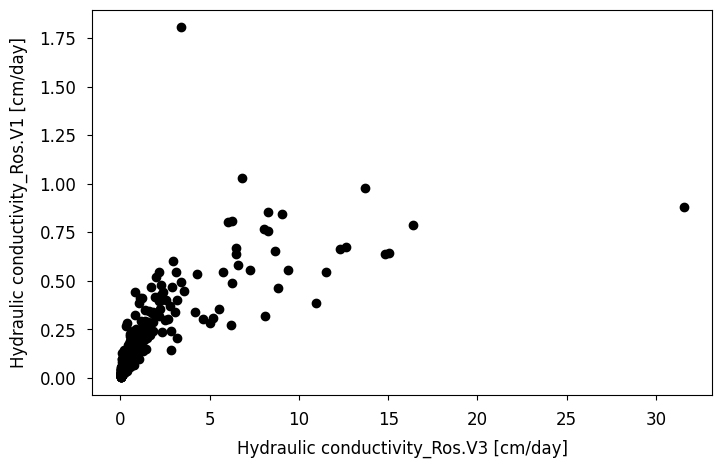

In [ ]:
#Plotting hydraulic conductivity values obtained from Rosetta versions 1 and 3
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.xlabel('Hydraulic conductivity_Ros.V3 [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity_Ros.V1 [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(K3, K1, 'ok')

Text(0.5, 0.85, 'y = 0.19x + 2.60\nR² = 0.948')

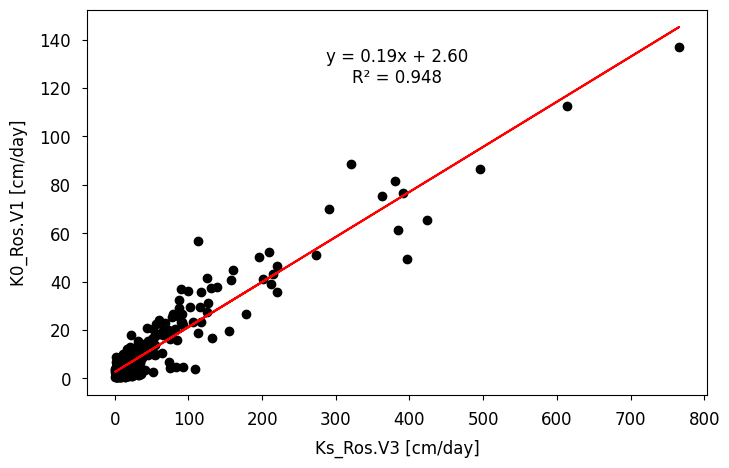

In [ ]:
# Plotting K0 from Rosetta V1 versus Ks from Rosetta V3
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.xlabel('Ks_Ros.V3 [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('K0_Ros.V1 [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(Ks_3, K0, 'ok')

# Linear regression
from scipy.stats import linregress

# Create a boolean list 'valid indices'containing valid elements of K3 and K0 pair
valid_indices = [not (np.isnan(K3) or np.isnan(K0)) for K3, K0 in zip(Ks_3, K0)]
x = [K3 for K3, valid in zip(Ks_3, valid_indices) if valid]
y = [K0 for K0, valid in zip(K0, valid_indices) if valid]

# Perform linear regression
slope, intercept, r_squared, p_value, std_err = linregress(x, y)

# Plotting the regression line
# Calculate the y value using the linear regression equation and plots the result with the corresponding x value
plt.plot(x, [slope*k + intercept for k in x], '-r')

# Adding the equation of the line and R-squared value in the plot
# Construct a string equation using 'f' string
# \n creates a new string
# Indicate the position of the strings in the plot
equation = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.3f}'
plt.text(0.5, 0.85, equation, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

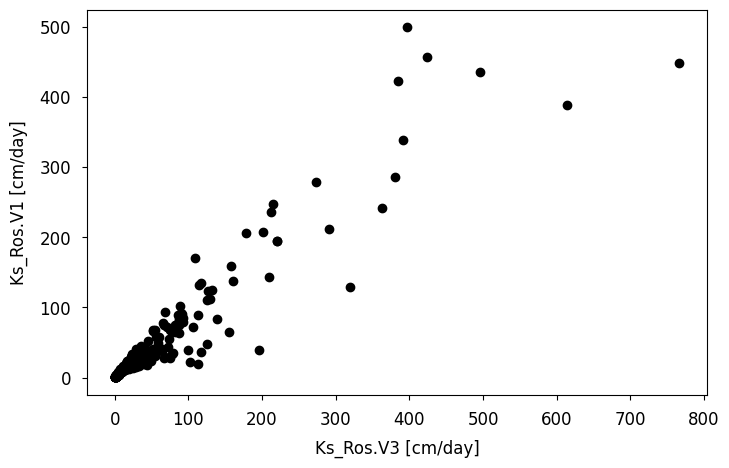

In [ ]:
#Plotting Ks values from Rosetta versions 1 and 3
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.xlabel('Ks_Ros.V3 [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('Ks_Ros.V1 [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(Ks_3, Ks_1, 'ok')